# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and we're doing GANs in a project for the first time, we want test our neural network on MNIST before CelebA.  Running the GANs on MNIST will allow us to see how well our model trains sooner.

In [1]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('celeba', data_dir)

Found celeba Data


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

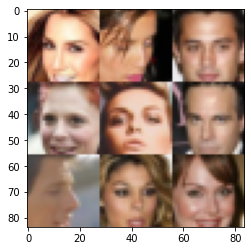

In [2]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.5.0
Default GPU Device: /device:GPU:0


In [4]:
from tensorflow.keras import layers

### Discriminator

In [5]:
def discriminator(alpha=0.2):

    model = tf.keras.Sequential()

    # Input to 3D cube reshape
    model.add(layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), input_shape=(28,28,3)))
    model.add(layers.Conv2D(16, kernel_size=(5,5), strides=(1,1)))
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(32, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(256, kernel_size=(5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [6]:
d =discriminator()
d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 16)        3216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        12832     
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          5

### Generator

In [7]:
def generator(alpha=0.2):
    model = tf.keras.Sequential()

    # Input to 3D cube reshape
    model.add(layers.Dense(2*2*1024, input_shape=(100,)))
    model.add(layers.Reshape((2,2,1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(32, (5,5), strides=(1,1), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2DTranspose(16, (5,5), strides=(2,2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))

    model.add(layers.Conv2D(8, (5,5), strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha))
    
    model.add(layers.Conv2D(3, (3,3), strides=(1,1), padding="same", activation="tanh"))
    
    return model

In [8]:
g = generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 1024)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 1024)        4096      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         6553856   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 256)        

### Loss

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(cross_entropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(cross_entropy(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import matplotlib.pyplot as plt

def view_samples(samples, nrows, ncols,  epoch=-1 ,figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    samples = samples[epoch]

    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        # img = np.array((img*127.5 + 127.5),dtype=np.int32)
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

### CelebA

In [11]:
batch_size = 200
z_dim = 100
learning_rate = 0.01
beta1 = 0.5
epochs = 10
losses = []
samples = []


generator_model = generator()
discriminator_model = discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.001, beta_1= beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001, beta_1= beta1)

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
for e in range(epochs):
    i = 0
    for x in celeba_dataset.get_batches(batch_size):
        i += 1
        noise = tf.random.normal([batch_size, z_dim])  # Z input

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator_model(noise, training=True)

            real_output = discriminator_model(x, training=True)
            fake_output = discriminator_model(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

        
        if(i%5==0):
            losses.append((disc_loss, gen_loss))
            print(f"Batch gen-loss={gen_loss} disc_loss={disc_loss}")

        if(i%100==0):
            noise = tf.random.normal([16, z_dim])
            predictions = generator_model(noise, training=False)
            print(f"Batch gen-loss={gen_loss} disc_loss={disc_loss}")
            predictions = predictions.numpy()

            samples.append(predictions)
            losses.append((disc_loss, gen_loss))

    print(f"Epoch {e+1} completed!")

Batch gen-loss=10.541864395141602 disc_loss=0.18517805635929108
Batch gen-loss=0.001114065758883953 disc_loss=6.858925819396973
Batch gen-loss=8.634134292602539 disc_loss=0.16165098547935486
Batch gen-loss=4.906348705291748 disc_loss=0.05753691866993904
Batch gen-loss=0.13454517722129822 disc_loss=2.176387310028076
Batch gen-loss=2.7649624347686768 disc_loss=0.2453886866569519
Batch gen-loss=4.2440948486328125 disc_loss=0.035259224474430084
Batch gen-loss=3.6726012229919434 disc_loss=0.11726310104131699
Batch gen-loss=0.7080559730529785 disc_loss=0.7258049845695496
Batch gen-loss=3.964883327484131 disc_loss=0.1574651002883911
Batch gen-loss=0.06365402042865753 disc_loss=2.878830671310425
Batch gen-loss=4.968756198883057 disc_loss=0.19088269770145416
Batch gen-loss=2.4604921340942383 disc_loss=0.14607146382331848
Batch gen-loss=0.10404865443706512 disc_loss=2.4118616580963135
Batch gen-loss=6.515020370483398 disc_loss=0.35692816972732544
Batch gen-loss=5.759918212890625 disc_loss=0.3500

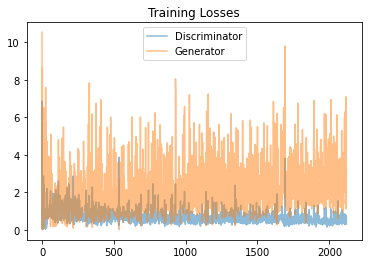

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

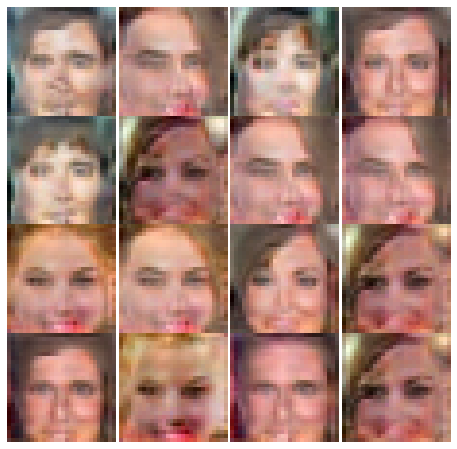

In [13]:
_ = view_samples(samples, 4, 4, figsize=(8,8), epoch=-1)